In [1]:
import sklearn
import csv
import cv2
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
from os import getcwd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.utils import shuffle


Using TensorFlow backend.


done


In [2]:
#this function will crop and resize the images to save memory and make training faster
#reduce the noise and use cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV) as the Nvidia doc suggests,
def preprocess_image(img):
    #avoid input size error in keras model
    new_img = img[50:140,:,:]
    new_img = cv2.GaussianBlur(new_img, (3,3), 0)
    new_img = cv2.resize(new_img,(200, 66), interpolation = cv2.INTER_AREA)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img


Done


In [3]:
# here we are creating extra training data
def generate_training_data(image_paths, angles, batch_size=128):
    image_paths, angles = shuffle(image_paths, angles)
    X,y = ([],[])
    while True:       
        for i in range(len(angles)):
            img = cv2.imread(image_paths[i])
            angle = angles[i]
            img = preprocess_image(img)
            X.append(img)
            y.append(angle)
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)
            # flip horizontally and invert steer angle, if magnitude is > 0.33 to avoid adding 
            # too much data without meaningful change
            if abs(angle) > 0.33:
                img = cv2.flip(img, 1)
                angle *= -1
                X.append(img)
                y.append(angle)
                if len(X) == batch_size:
                    yield (np.array(X), np.array(y))
                    X, y = ([],[])
                    image_paths, angles = shuffle(image_paths, angles)


done


In [5]:
#Here we are opening the driving_log file provided and reading the data
lines=[]
image_paths = []
angles = []
img_path_prepend = ['', getcwd() + './data/']
pathnw ="C:/Users/Abdullah's/CarND-Behavioral-Cloning-P3-master/driving_log.csv"
with open(pathnw) as csvfile:
    driving_data = list(csv.reader(csvfile, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
    for row in driving_data[1:]:
        # skip it if ~0 speed - not representative of driving behavior
        if float(row[6]) < 0.1 :
            continue
        # get center image path and angle
        image_paths.append(img_path_prepend[1] + row[0])
        angles.append(float(row[3]))
        # get left image path and angle
        image_paths.append(img_path_prepend[1] + row[1])
        #add a correction factor of .25 to the angle
        angles.append(float(row[3])+0.25)
        # get left image path and angle
        image_paths.append(img_path_prepend[1] + row[2])
        # add a correction factor of -.25 to the angle
        angles.append(float(row[3])-0.25)

image_paths = np.array(image_paths)
angles = np.array(angles)
print('Size of data:', image_paths.shape, angles.shape)
print('Size of data:', image_paths.shape, angles.shape)

Size of data: (3831,) (3831,)
Size of data: (3831,) (3831,)


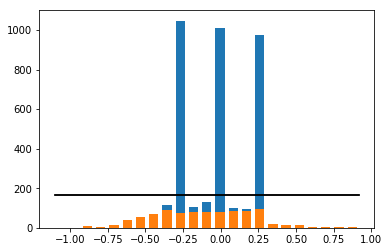

Size of data after removing unwanted values: (927,) (927,)


In [6]:
# this is basically clean up tp the data that we have so that we dont overwhelm our machine while training (cause biases)
num_bins = 23
avg_samples_per_bin = len(angles)/num_bins
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
#set keep probability for data from steering angles with more than half the average samples per angle
keep_probs = []
target = avg_samples_per_bin * .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(angles)):
    for j in range(num_bins):
        if angles[i] > bins[j] and angles[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
image_paths = np.delete(image_paths, remove_list, axis=0)
angles = np.delete(angles, remove_list)

# print histogram to show the new distribution of steering angles
hist, bins = np.histogram(angles, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

print('Size of data after removing unwanted values:', image_paths.shape, angles.shape)

In [7]:
# this is the Nvidia architecture modle 
model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(66,200,3)))
##Nvidia Model
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

train_gen = generate_training_data(image_paths, angles, batch_size=64)
val_gen = generate_training_data(image_paths, angles, batch_size=64)

history = model.fit_generator(train_gen, validation_data=val_gen, nb_val_samples=2560, samples_per_epoch=23040, 
                                  nb_epoch=5, verbose=2, callbacks=[checkpoint])

model.save('model.h5')
print("done")

Epoch 1/5
154s - loss: 0.0331 - val_loss: 0.0242
Epoch 2/5
44s - loss: 0.0205 - val_loss: 0.0187
Epoch 3/5
93s - loss: 0.0158 - val_loss: 0.0129
Epoch 4/5
95s - loss: 0.0106 - val_loss: 0.0073
Epoch 5/5
53s - loss: 0.0067 - val_loss: 0.0050
done
